# photoeccentric with real Kepler light curves

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [284]:
nwalk = 64
nsteps_d = 1500
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [285]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [268]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_incmissing.txt", sep=" ")

In [269]:
# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
# TODO: Vet based on KOI not KIC
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
#spectplanets = spectplanets[spectplanets['koi_disposition'] != 'FALSE POSITIVE']

# spectplanets.to_csv('spectplanets.csv')

In [270]:
# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.rename(columns={"source_id": "m_source_id"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.merge(muirhead_data, muirhead_gaia, how='inner', left_on='KIC', right_on='kepid')
#muirhead_comb.to_csv('muirhead_comb.csv')

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb[muirhead_comb.lum_val.notnull()]
#muirhead_comb_lums.to_csv('muirhead_comb_lums.csv')

/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ssagear/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [271]:
# Is the spectplanets array the same as the Muirhead sample?

np.all(np.sort(np.unique(np.array(muirhead_data['KIC']))) == np.sort(np.unique(np.array(spectplanets['kepid']))))

True

In [409]:
muirhead_comb = pd.read_csv('muirhead_comb.csv')

In [415]:
muirhead_comb

,Unnamed: 0,KOI,KIC,Teff,ETeff,eTeff,Fe/H,e_Fe/H,M/H,e_M/H,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
0,0,4290,5868793,3187,62,88,+0.10,0.16,+0.07,0.13,...,-0.040,b'MULT70',1,1,1,13.285,12.694,12.435,b'conf',0.260351
1,1,2842,8733898,3204,40,67,-0.30,0.12,-0.21,0.12,...,-0.043,b'DSEP',3,3,3,13.591,13.075,12.827,b'conf',0.075728
2,2,961,8561063,3204,59,46,-0.48,0.12,-0.33,0.12,...,-0.013,b'DSEP',3,3,4,12.177,11.685,11.465,b'conf',0.061480
3,3,1725B,10905746,3253,62,57,+0.16,0.13,+0.11,0.12,...,-0.066,b'DSEP',1,1,2,10.648,9.979,9.804,b'conf',1.243261
4,4,1725B,10905746,3253,62,57,+0.16,0.13,+0.11,0.12,...,-0.066,b'DSEP',1,1,2,10.648,9.979,9.804,b'conf',2.861576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,130,3140,5978170,X,X,X,X,X,X,X,...,-0.056,b'DSEP',0,1,1,13.523,12.886,12.775,b'cand',0.235430
131,131,3414,6023859,X,X,X,X,X,X,X,...,-0.056,b'DSEP',0,1,1,13.372,12.674,12.517,b'cand',0.033447
132,132,4087,6106282,X,X,X,X,X,X,X,...,-0.034,b'DSEP',1,1,1,12.960,12.323,12.121,b'conf',0.159269
133,133,4463SE,6197344,X,X,X,X,X,X,X,...,-0.061,b'DSEP',0,1,1,12.895,12.549,12.545,b'cand',0.839986


In [418]:
muirhead_comb[muirhead_comb['KOI'] == '4290'].KIC.item()

5868793

In [272]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))

In [279]:
KICs

array([ 2161536,  2556650,  2973386,  2986833,  3426367,  3642335,
        4061149,  4139816,  4172805,  4725681,  4913852,  5080636,
        5131180,  5364071,  5384713,  5531953,  5551672,  5601258,
        5688790,  5794240,  5809954,  5868793,  5978170,  6023859,
        6106282,  6149553,  6183511,  6186964,  6197344,  6382217,
        6435936,  6497146,  6609270,  6666233,  6679295,  6773862,
        7021681,  7094486,  7304449,  7455287,  7603200,  7870390,
        7907423,  8120608,  8167996,  8229458,  8235924,  8346392,
        8351704,  8367644,  8424002,  8509442,  8561063,  8631751,
        8733898,  8845205,  8890150,  9150827,  9202151,  9388479,
        9390653,  9427402,  9573685,  9654468,  9710326,  9730163,
        9757613,  9761199,  9787239,  9837661, 10027247, 10073672,
       10118816, 10122538, 10166274, 10329835, 10332883, 10386984,
       10388286, 10395543, 10489206, 10525027, 10525049, 10591855,
       10670119, 10905746, 10990886, 11129738, 11187837, 11192

In [273]:
#np.savetxt('MuirheadKICS.csv', KICs, delimiter=',')

In [274]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
lclist = []

for i in range(len(KICs)):
    templst = []
    for subdir, dirs, files in os.walk(lcpath):
        for file in files:
            if str(KICs[i]) in file:
                templst.append(os.path.join(subdir, file))
    lclist.append(templst)

In [275]:
def get_stitched_lcs(KIC):
    
    files = lclist[int(np.argwhere(KICs==KIC))]
    
    time = []
    flux = []
    flux_err = []
    
    for file in files:
        hdu = fits.open(file)
        time.append(list(hdu[1].data['TIME'] + hdu[1].header['BJDREFI']))
        flux.append(list(hdu[1].data['PDCSAP_FLUX']/np.nanmedian(hdu[1].data['PDCSAP_FLUX'])))
        flux_err.append(list(hdu[1].data['PDCSAP_FLUX_ERR']/np.nanmedian(hdu[1].data['PDCSAP_FLUX'])))
        hdu.close()
    
    return time, flux, flux_err

In [280]:
t, f, fe = get_stitched_lcs(8424002)

In [281]:
alltime = []
allflux = []
allfluxerr = []

for sublist in t:
    for item in sublist:
        alltime.append(item)
        
for sublist in f:
    for item in sublist:
        allflux.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr.append(item)

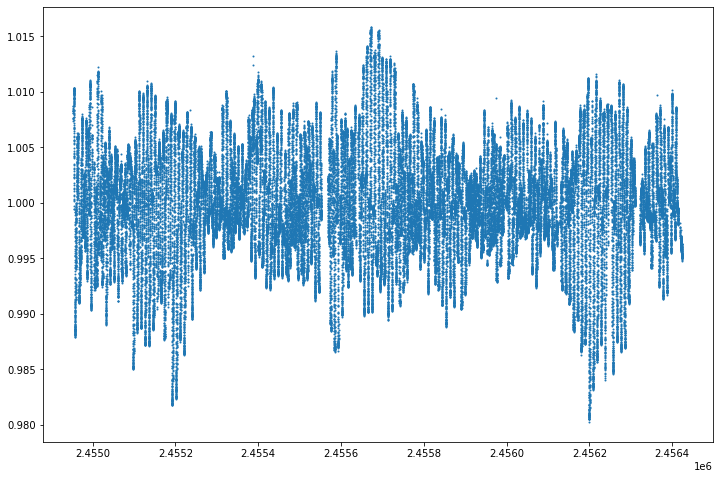

In [282]:
plt.scatter(alltime, allflux, s=1)

# Isochrone fitting for all targets 

In [401]:
spectplanets = pd.read_csv('spectplanets.csv')
muirhead_comb = pd.read_csv('muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('muirhead_lamost.csv')

In [313]:
# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

In [404]:
def get_all_stellar_data(kepid, isochrones):
    
    #kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

    kpdata = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]
    
    kpdata = kpdata.iloc[0]
    
    iso_lums = ph.fit_isochrone_lum(kpdata, muirhead_comb_lums, isochrones, gaia_lum=False, source='Muirhead')

    # Write to csv, then read back in (prevents python notebook from lagging)
    iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")
    
    
def read_isochrones(kepid, planetnum):
    
    isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")
    
    return isodf


In [406]:
for i in range(11, len(KICs)):
    
    kepid = KICs[i]
        
    try:
        get_all_stellar_data(kepid, isochrones)
    except ValueError:
        continue


100%|██████████| 738479/738479 [04:18<00:00, 2854.44it/s]


In [393]:
spectplanets

,Unnamed: 0,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,64,11923270,K00781.01,Kepler-676 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,-0.03,0.082,0.066,0.095,0.29,0.110,0.628,0.080,0.690,0.086
1,85,4139816,K00812.02,Kepler-235 d,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,-0.03,0.140,0.030,0.140,-0.18,0.140,-0.150,0.140,0.230,0.140
2,86,4139816,K00812.03,Kepler-235 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.04,0.220,0.080,0.210,-0.25,0.170,-0.060,0.160,0.260,0.170
3,88,4139816,K00812.04,Kepler-235 c,CONFIRMED,Done,8/16/18,CANDIDATE,0.994,0,...,-0.45,0.390,0.550,0.350,0.11,0.300,-0.580,0.430,0.590,0.400
4,105,4139816,K00812.01,Kepler-235 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.05,0.097,0.060,0.110,-0.15,0.092,-0.039,0.092,0.154,0.092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,7606,10122538,K02926.04,Kepler-1388 e,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.15,0.220,0.250,0.220,-0.02,0.220,0.000,0.200,0.020,0.220
163,7610,6609270,K03090.02,NaN,FALSE POSITIVE,Done,8/16/18,FALSE POSITIVE,0.022,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,8590,11129738,K01427.02,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.891,0,...,1.05,0.460,1.140,0.460,-0.35,0.460,0.810,0.460,0.880,0.460
165,8593,5531953,K01681.04,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.999,0,...,-0.03,0.550,0.160,0.940,0.00,1.200,-0.280,0.540,0.280,0.580


In [353]:
isodf = read_isochrones(KICs[0], 3)

In [356]:
mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

# Fitting Kepler-61 b

In [197]:
hdu = fits.open('datafiles/MAST_2021-04-27T1542/Kepler/kplr006960913_lc_Q011111111111111111/kplr006960913-2010265121752_llc.fits')
time = hdu[1].data['TIME'] + hdu[1].header['BJDREFI']
flux = hdu[1].data['PDCSAP_FLUX']
flux_err = hdu[1].data['PDCSAP_FLUX_ERR']

In [198]:
fmed = np.nanmedian(flux)

flux = flux/fmed
flux_err = flux_err/fmed

In [199]:
period = 59.87756

t0 = hdu[1].header['BJDREFI']
tm1 = hdu[1].header['BJDREFI']+period*100
tmidtimes = np.arange(t0, tm1, period)

In [200]:
midjd = np.genfromtxt('datafiles/keplerstellar/kep61-mpts.csv', delimiter=',')[1:]

In [201]:
#midjd

In [202]:
cmtimes = []
for j in range(len(midjd)):
    if time[0] < midjd[j] < time[-1]:
        cmtimes.append(midjd[j])

In [203]:
transitmid = cmtimes[0]

In [204]:
start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI']
end = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI']

In [205]:
mid = ph.get_mid(time)

In [206]:
tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

n = 20

t1 = time[tindex-n:tindex+n] - transitmid
f1 = flux[tindex-n:tindex+n]
fe1 = flux_err[tindex-n:tindex+n]

(0.99, 1.01)

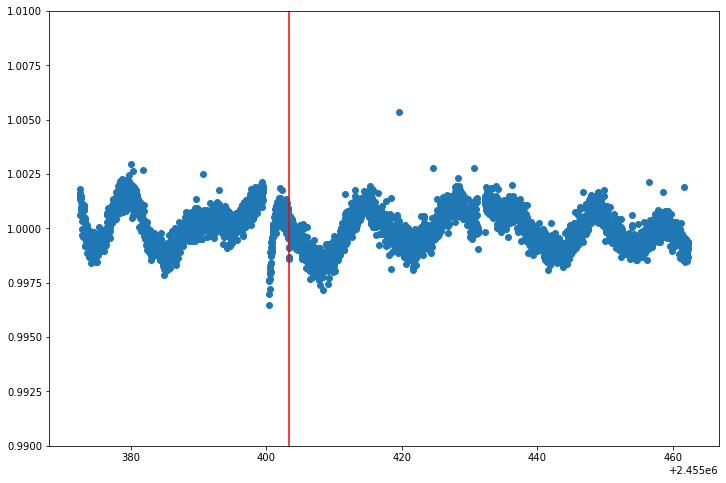

In [207]:
plt.scatter(time, flux)
plt.axvline(transitmid, c='r')
plt.ylim(.990, 1.010)

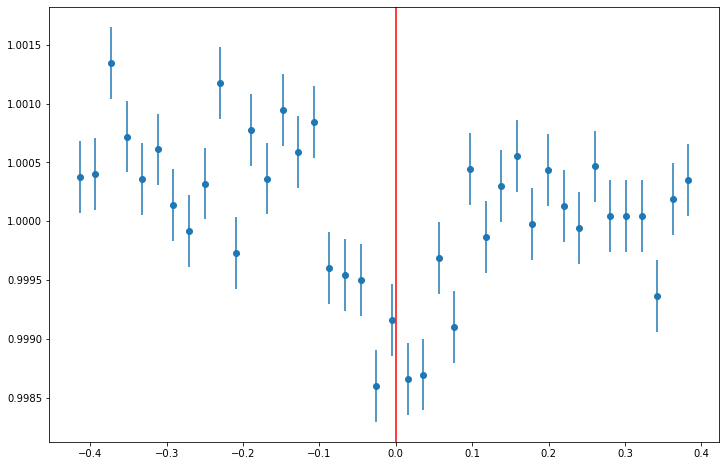

In [208]:
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')


In [209]:
idx = np.isfinite(t1) & np.isfinite(f1)

disc = 15

m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

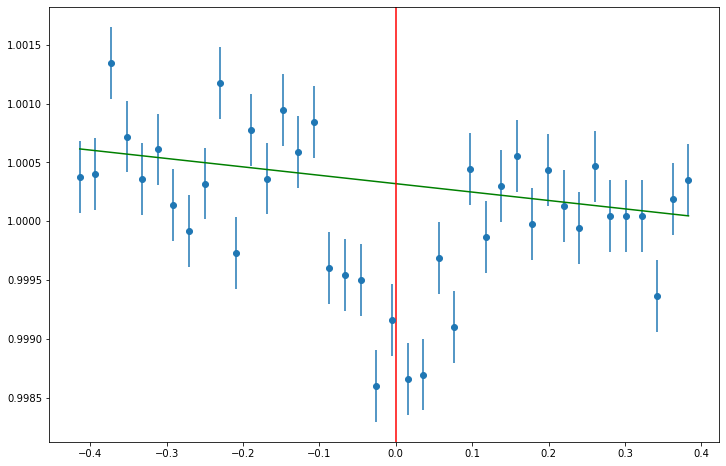

In [210]:
plt.plot(t1, m*t1 + b, c='g')
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [211]:
linfit = m*t1 + b
fnorm = (f1-linfit)+1

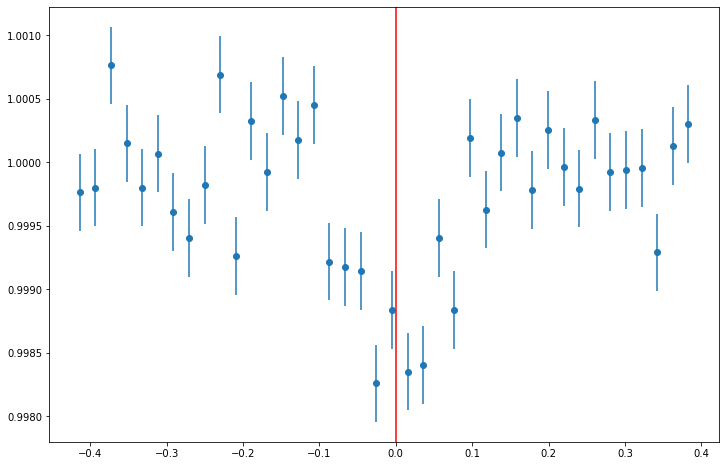

In [212]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [213]:
ptime = ph.get_ptime(t1, mid, 29)
fnorm = np.nan_to_num(fnorm, nan=1.0)
fe1 = np.nan_to_num(fe1, nan=1.0)

In [214]:
pdist = np.random.normal(59.9, 1, arrlen)

In [ ]:
# Inital guess: per, rprs, a/Rs, i
p0 = [0.04, 90, 89.9]

dr = 'Kepler61'
direct = 'plots/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, rdist, adist, idist = ph.mcmc_fitter_noper(p0, 59.87756, t1, ptime, fnorm, fe1, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct)

  5%|▌         | 78/1500 [00:06<02:02, 11.65it/s]

In [ ]:
# Create a light curve with the fit parameters

mcmcfit = ph.integratedlc_fitter(t1, ph.mode(pdist), ph.mode(rdist), ph.mode(adist), ph.mode(idist))

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()

In [ ]:
ph.mode(rdist)

In [ ]:
ph.mode(adist)

In [ ]:
ph.mode(idist)

In [ ]:
ph.mode(pdist)

# Kepler-1582 b

In [61]:
pname = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/MAST_2021-05-07T1328/Kepler/kplr005868793_lc_Q000000111100000000/kplr005868793-2010355172524_llc.fits'
hdu = fits.open(pname)

time = hdu[1].data['TIME'] + hdu[1].header['BJDREFI']
flux = hdu[1].data['PDCSAP_FLUX']
flux_err = hdu[1].data['PDCSAP_FLUX_ERR']



In [62]:
fmed = np.nanmedian(flux)

flux = flux/fmed
flux_err = flux_err/fmed

In [63]:
period = 4.8

t0 = hdu[1].header['BJDREFI']
tm1 = hdu[1].header['BJDREFI']+period*100
tmidtimes = np.arange(t0, tm1, period)

In [64]:
midjd = np.genfromtxt('datafiles/keplerstellar/kep1582-mpts.txt', delimiter=' ')[1:]

In [65]:
cmtimes = []
for j in range(len(midjd)):
    if time[0] < midjd[j] < time[-1]:
        cmtimes.append(midjd[j])

In [66]:
cmtimes

[2455466.47869,
 2455471.31684,
 2455476.15499,
 2455480.99314,
 2455485.83128,
 2455490.66944,
 2455495.50758,
 2455500.34573,
 2455505.18388,
 2455510.02203,
 2455514.86018,
 2455519.69833,
 2455524.53648,
 2455529.37463,
 2455534.21278,
 2455539.05093,
 2455543.88908,
 2455548.72723]

In [153]:
transitmid = cmtimes[5]

In [154]:
start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI']
end = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI']

In [155]:
mid = ph.get_mid(time)

In [172]:
tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

n = 15

t1 = time[tindex-n:tindex+n] - transitmid
f1 = flux[tindex-n:tindex+n]
fe1 = flux_err[tindex-n:tindex+n]

(0.99, 1.01)

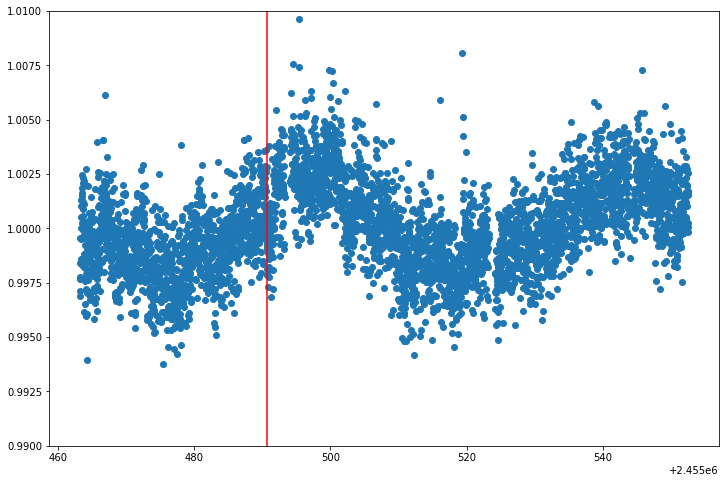

In [173]:
plt.scatter(time, flux)
plt.axvline(transitmid, c='r')
plt.ylim(.990, 1.010)

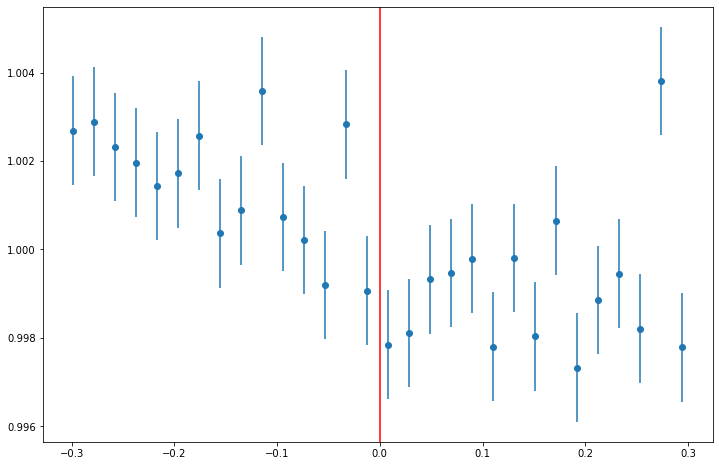

In [174]:
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')


In [175]:
idx = np.isfinite(t1) & np.isfinite(f1)

disc = 15

m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

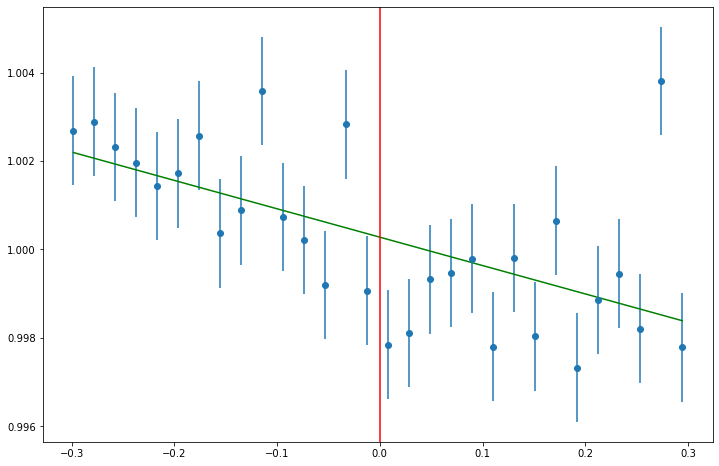

In [176]:
plt.plot(t1, m*t1 + b, c='g')
plt.errorbar(t1, f1, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [177]:
linfit = m*t1 + b
fnorm = (f1-linfit)+1

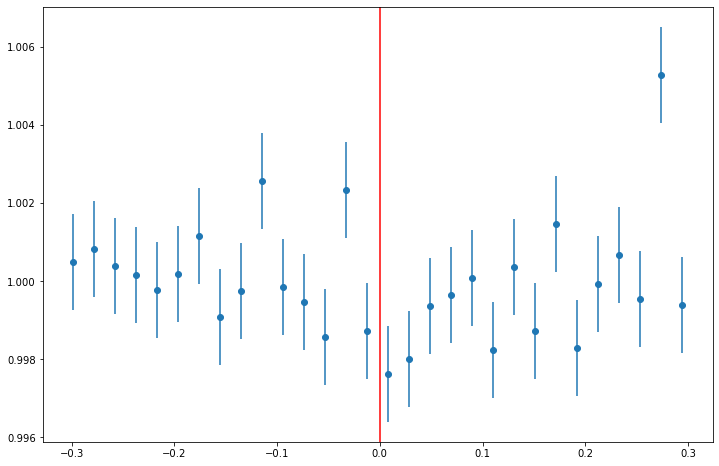

In [178]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [179]:
ptime = ph.get_ptime(t1, mid, 29)
fnorm = np.nan_to_num(fnorm, nan=1.0)
fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))

In [186]:
fnorm[np.argmax(fnorm)] = np.nanmedian(fnorm)

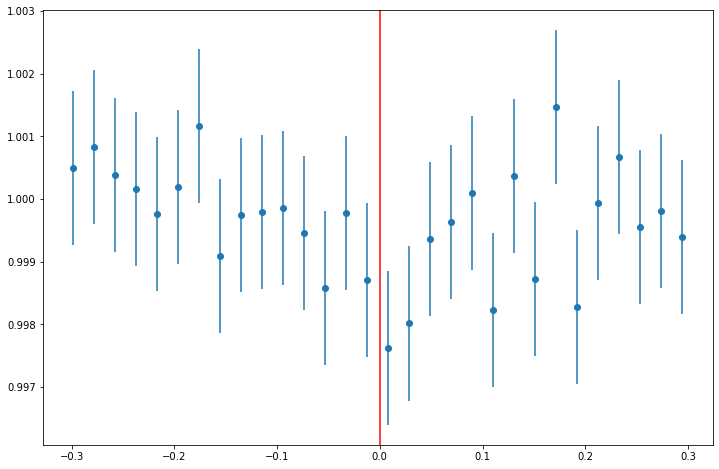

In [187]:
plt.errorbar(t1, fnorm, yerr=fe1, fmt='o')
plt.axvline(0, c='r')

In [188]:
pdist = np.random.normal(59.9, 1, arrlen)

In [189]:
# Inital guess: rprs, a/Rs, i, w
p0 = [0.035, 32, 89.9]

dr = 'Kepler1582'
direct = 'plots/' + dr + '/'

if not os.path.exists(direct):
    os.mkdir(direct)

# EMCEE Transit Model Fitting
_, _, rdist, adist, idist = ph.mcmc_fitter_noper(p0, 4.8, t1, ptime, fnorm, fe1, nwalk, nsteps_d, ndiscard_d, 'X', 'X', direct)

100%|██████████| 1500/1500 [01:09<00:00, 21.65it/s]


In [190]:
ph.mode(rdist)

0.06099069553355093

In [191]:
ph.mode(adist)

603034459022848.0

In [192]:
ph.mode(idist)

0.0047253271005445185

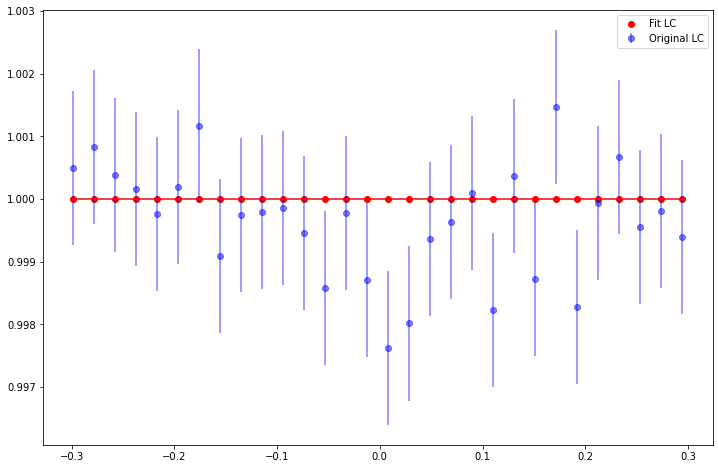

In [193]:
# Create a light curve with the fit parameters

mcmcfit = ph.integratedlc_fitter(t1, 4.8, ph.mode(rdist), ph.mode(adist), ph.mode(idist))

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()

# Start over omg

https://emcee.readthedocs.io/en/stable/tutorials/line/

In [92]:
import batman

In [93]:
def integrate_lcfitter(time, rp, ars, inc):
    
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0                        #time of inferior conjunction
    params.per = 59.0                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = ars                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = 0.0                      #eccentricity
    params.w = 0.0                       #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.5, 0.2]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    ptime = get_ptime(time, 0.010217133909463882, 29)
    
    m = batman.TransitModel(params, ptime)
    
    pflux = m.light_curve(params)
    flux = array_integrated(pflux, 29)
    
    return flux

In [44]:
soln = [0.03301, 90.6, 89.9] # r, ars, i

In [45]:
def log_likelihood(theta, time, flux, fluxerr):
    rp, ars, inc = theta
    model = integrate_lcfitter(time, rp, ars, inc)
    sigma2 = fluxerr ** 2
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(sigma2))

In [46]:
def log_prior(theta):
    rp, ars, inc = theta
    if 0.0 < rp < 1.0 and 0.0 < ars < 200.0 and 0.0 < inc < 90.0:
        return 0.0
    return -np.inf

In [47]:
def log_probability(theta, time, flux, fluxerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, fluxerr)

In [48]:
pos = soln + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(t1, fnorm, fe1))
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [05:35<00:00, 14.90it/s]


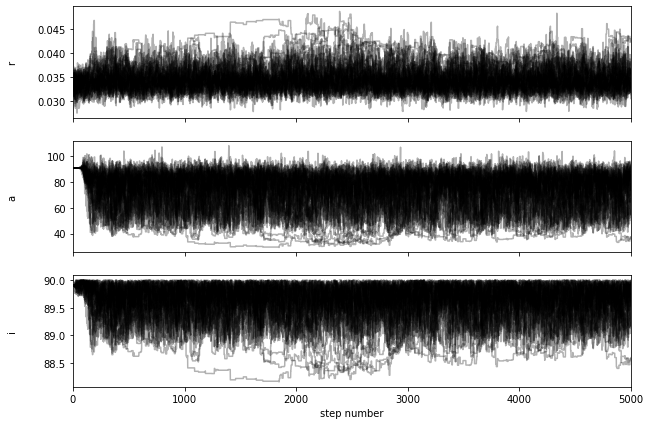

In [49]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["r", "a", "i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [50]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [51]:
flat_samples[:1]

array([[3.42413410e-02, 8.96678995e+01, 8.99704641e+01]])

In [52]:
rprsf = np.nanmean(flat_samples[:,0])
af = np.mean(flat_samples[:,1])
incf = np.mean(flat_samples[:,2])

In [53]:
print(rprsf, af, incf)

0.03497637582580567 71.48265626404638 89.54095494597688


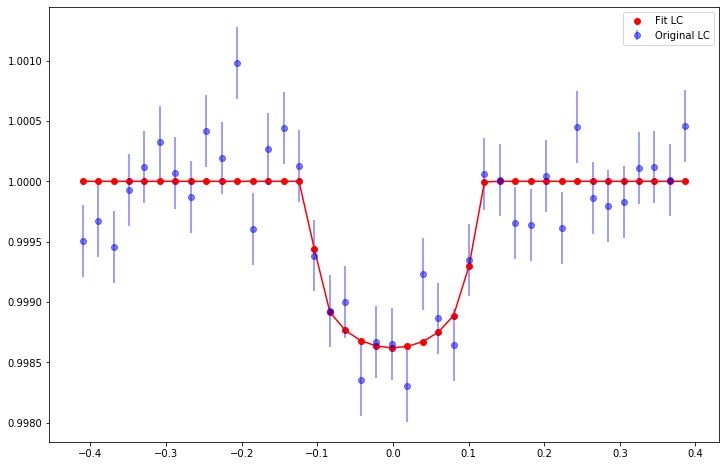

In [55]:
# Create a light curve with the fit parameters

mcmcfit = integrate_lcfitter(t1, rprsf, af, incf)

plt.errorbar(t1, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
plt.scatter(t1, mcmcfit, c='red', alpha=1.0, label='Fit LC')
plt.plot(t1, mcmcfit, c='red', alpha=1.0)

plt.legend()